# Hot to setup Plotly APIs for plotting a map of Italy in Python

In this tutorial I will use a synthetic dataset containing some random information of people to plot a [Choropleth Mapbox](https://plot.ly/python/choropleth-maps/) of districts in Italy.

## Read the data

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("data.zip")
df.head()

,id,cap,city,district,birth_date,age,age_younger_son,n_fam_dependent,n_fam_old,n_sons,...,n_people_city,job,prop_delegate,prop_risk,status,education,heritage,city_name,prov_name,reg_name
0,1,87032,78010,78,1992-07-15,27,1.0,2,0,1,...,13754,5,2,2,7,1,1,Amantea,Cosenza,Calabria
1,2,40033,37011,37,1944-07-10,75,0.0,5,2,3,...,35173,8,2,1,2,5,7,Casalecchio di Reno,Bologna,Emilia-Romagna
2,3,7046,90058,90,1968-05-14,51,5.0,4,1,2,...,22391,2,2,1,7,1,5,Porto Torres,Sassari,Sardegna
3,4,25020,17177,17,1948-09-17,71,41.0,0,0,1,...,1581,8,2,2,6,2,6,Seniga,Brescia,Lombardia
4,5,33048,30101,30,1980-09-05,39,10.0,2,0,1,...,6117,6,1,1,5,4,9,San Giovanni al Natisone,Udine,Friuli-Venezia Giulia


In [3]:
df.columns

Index(['id', 'cap', 'city', 'district', 'birth_date', 'age', 'age_younger_son',
       'n_fam_dependent', 'n_fam_old', 'n_sons', 'income_bracket', 'sex',
       'lat', 'long', 'n_people_city', 'job', 'prop_delegate', 'prop_risk',
       'status', 'education', 'heritage', 'city_name', 'prov_name',
       'reg_name'],
      dtype='object')

## Prepare data

Before feeding data to the API we need to prepare the data correctly. I create a DataFrame where each row contains the district and the number of people that come from that district.

In [4]:
data = df.groupby(["district","prov_name"]).size().reset_index()
print(data.head())
data = data.rename(columns={0:'count'})
print(data.head())

   district prov_name    0
0         1    Torino  395
1         2  Vercelli   76
2         3    Novara  100
3         4     Cuneo  309
4         5      Asti  120
   district prov_name  count
0         1    Torino    395
1         2  Vercelli     76
2         3    Novara    100
3         4     Cuneo    309
4         5      Asti    120


## Setup of APIs

To create the map of any country you need a JSON document describing geograpichally the country, for example which and where regions are ecc...
Usually we look for ready to use JSONs.
The Plotly API docs present only JSON for the USA, so we need to search the JSON for the desired country.
Luckily I found [this](https://github.com/Dataninja/geo-shapes) repo that contains all we need.

In [5]:
import plotly.express as px

from urllib.request import urlopen
import json

geo_url = 'https://raw.githubusercontent.com/Dataninja/geo-shapes/master/italy/provinces.geojson'
with urlopen(geo_url) as f:
    geojson = json.load(f)

You can now choose different kinds of maps, here I present the [Choropleth Mapbox](https://plot.ly/python/choropleth-maps/).

In [6]:
fig = px.choropleth_mapbox(data, geojson=geojson,hover_data=["prov_name"],
                           locations="district", color="count",#columns taken into consideration for locations and colors
                           featureidkey="properties.COD_PRO",
                           center={"lat": 41.902782, "lon": 12.496366}, #centered in Rome
                           mapbox_style="carto-positron", zoom=4)

Here `locations` represents the column of the DataFrame that contains codes of districts, while `color` is the column that contains the total number of people.
The others fields are self-explanatory, but what I found not very clear was `featureidkey`. It represents the field in the JSON file that will be matched with the `district` column of the DataFrame when displaying the plot.

In [7]:
geojson["features"][0]

{'type': 'Feature',
 'properties': {'COD_REG': 1, 'COD_PRO': 2, 'NOME_PRO': 'VERCELLI'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[8.204465116243027, 45.93567475731711],
    [8.302234192674149, 45.88827374491167],
    [8.293677590697104, 45.87046320612454],
    [8.335655912128695, 45.84571154577124],
    [8.317211157245648, 45.767770116210734],
    [8.357043818127059, 45.767686195175386],
    [8.391997164427195, 45.703477485696084],
    [8.310568166249642, 45.697208700325795],
    [8.390794743414515, 45.616644586898516],
    [8.4118759123609, 45.47997135788395],
    [8.400549555855369, 45.39619707797293],
    [8.43327251230752, 45.41208926657435],
    [8.45528017522559, 45.37824816487197],
    [8.496143208729952, 45.37417813926122],
    [8.499532709961944, 45.34775534685089],
    [8.462896601955821, 45.327233331586356],
    [8.51269363082711, 45.31688456965689],
    [8.498337440901357, 45.29222642075958],
    [8.514077166006121, 45.274320620697836],
    [8.535105940197045, 4

The key point here is the attribute `properties`:

In [8]:
geojson["features"][0]["properties"]

{'COD_REG': 1, 'COD_PRO': 2, 'NOME_PRO': 'VERCELLI'}

These are codes of the region and the district.
Since I want to represent in the map the distribution of people across districts, I wrote `featureidkey="properties.COD_PRO"` (PRO stands for provincia in Italian) as attribute in the constructor of `px.choropleth_mapbox`.
To ensure that we are using correct codes, let's explore the first row of the dataFrame and check if everything is ok.

In [9]:
data.head(3)

,district,prov_name,count
0,1,Torino,395
1,2,Vercelli,76
2,3,Novara,100


In [10]:
print(geojson["features"][0]["properties"])
print(geojson["features"][2]["properties"])
print(geojson["features"][1]["properties"])

{'COD_REG': 1, 'COD_PRO': 2, 'NOME_PRO': 'VERCELLI'}
{'COD_REG': 1, 'COD_PRO': 1, 'NOME_PRO': 'TORINO'}
{'COD_REG': 1, 'COD_PRO': 3, 'NOME_PRO': 'NOVARA'}


Ok, seems that codes used in our DataFrame agree with codes provided by the JSON.

For my task I created a random dataset of people. Features of this dataset are, among others:
    - City code
    - Number of people in the city
    - District code
    - Region code
    - Latitude
    - Longitude

Again, usually we look for a ready to use dataset with codes but over the web many of them are incomplete (and often outdated).
I found [this](https://github.com/matteocontrini/comuni-json) great repo (italian only) that contains almost every information I was looking for, except for latitude and longitude. So I forked the repo and added latitude and longitude for each city (I also created a pull-request to integrate my changes into the repository).

## Create the map

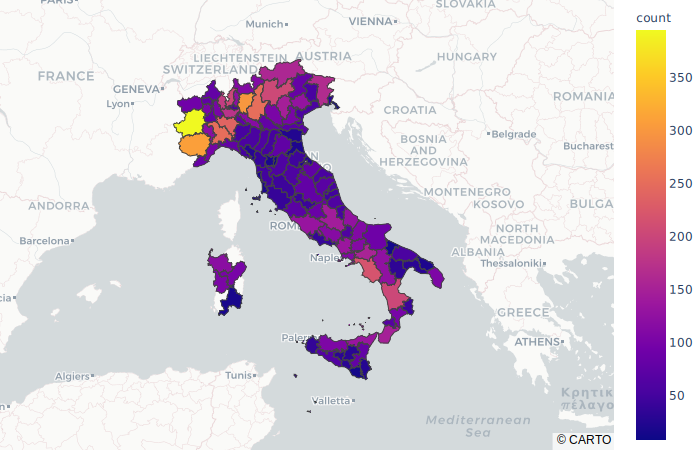

In [11]:
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("svg")

## Summary

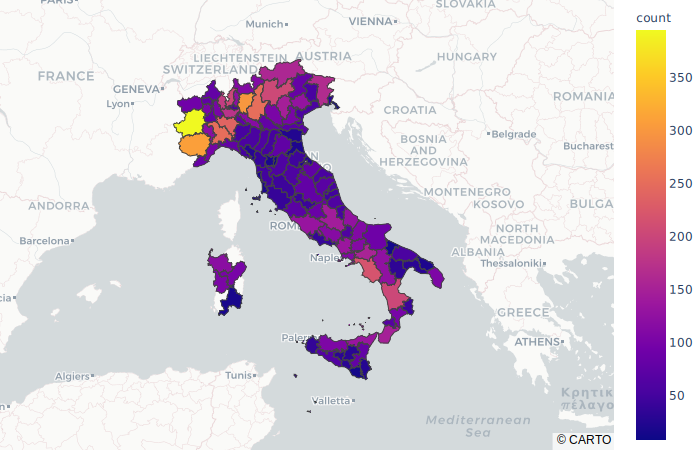

In [12]:
import pandas as pd
import plotly.express as px
from urllib.request import urlopen
import json

geo_url = 'https://raw.githubusercontent.com/Dataninja/geo-shapes/master/italy/provinces.geojson'

df = pd.read_csv("data.zip")
data = df.groupby(["district","prov_name"]).size().reset_index()
data = data.rename(columns={0:'count'})

with urlopen(geo_url) as f:
    geojson = json.load(f)
    
fig = px.choropleth_mapbox(data, geojson=geojson,hover_data=["prov_name"],
                           locations="district", color="count",#columns taken into consideration for locations and colors
                           featureidkey="properties.COD_PRO",
                           center={"lat": 41.902782, "lon": 12.496366}, #centered in Rome
                           mapbox_style="carto-positron", zoom=4)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("svg")